### Sustainable Energy Supply in On/Off Grid 
#### Taher Muhammedali
#### 478012
#### Homework 2

In [38]:
# Load libaries
import pandas as pd
from oemof import solph
from oemof.tools import economics
import matplotlib.pyplot as plt
from collections import OrderedDict

##### Exercise 1

In [39]:
# Reading input data

# Timeseries Data Reading
timeseries = pd.read_excel('input_data_assignment1.xls', 
                           sheet_name='timeseries', 
                           index_col=[0], 
                           parse_dates=True)
# Add timeindex frequency
timeseries.index.freq = '1H'

# Capacity Data Reading
capacities = pd.read_excel('input_data_assignment1.xls', 
                           sheet_name='capacity', 
                           index_col=[0])

# Cost Data Reading
costs = pd.read_excel('input_data_assignment1.xls', 
                           sheet_name='costs', 
                           index_col=[0])

# Tech Data Reading
tech = pd.read_excel('input_data_assignment1.xls', 
                           sheet_name='tech', 
                           index_col=[0])


In [40]:
# Creating Energy System Model
energysystem = solph.EnergySystem(timeindex=timeseries.index)

In [41]:
# Create oemof Bus

# create electricity bus
bus_electricity = solph.Bus(label='electricity_l')

# create heat bus
bus_heat = solph.Bus(label='heat_l')

# add buses to energy model
energysystem.add(bus_electricity, bus_heat)

In [42]:
# Create oemof Sinks

# create simple sink object representing the electrical demand
electricity_demand = solph.Sink(label='electricity_demand_l',
                                inputs={bus_electricity: solph.Flow(fix=timeseries['electricity'], 
                                                                    nominal_value=capacities['electricity']['amount'])
                                       }
                               )

# create excess component for the electricity bus to allow overproduction
electricity_excess = solph.Sink(label='electricity_excess_l', 
                    inputs={bus_electricity: solph.Flow()}
                   )

# create simple sink object representing the space heat demand
heat_space = solph.Sink(label='heat_space_demand_l',
                                inputs={bus_heat: solph.Flow(fix=timeseries['space_heat'], 
                                                                    nominal_value=capacities['space_heat']['amount'])
                                       }
                               )
# create simple sink object representing the hot water demand
heat_water = solph.Sink(label='heat_water_demand_l',
                                inputs={bus_heat: solph.Flow(fix=timeseries['dhw_heat'], 
                                                                    nominal_value=capacities['dhw_heat']['amount'])
                                       }
                               )
# create excess component for the heat bus to allow overproduction
heat_excess = solph.Sink(label='heat_excess_l',
                                inputs={bus_heat: solph.Flow() }
                               )

# All sinks to the energysystem
energysystem.add(electricity_excess, electricity_demand, heat_space, heat_water, heat_excess)

In [43]:
# Economic calculation (for sizing optimization)

cc_wind = economics.annuity(capex=costs['wind']['capex'], 
                            n=costs['wind']['lifetime'],
                            wacc=costs['wind']['wacc'])

cc_pv = economics.annuity(capex=costs['pv']['capex'], 
                            n=costs['pv']['lifetime'],
                            wacc=costs['pv']['wacc'])

cc_storage = economics.annuity(capex=costs['storage']['capex'], 
                               n=costs['storage']['lifetime'],
                               wacc=costs['storage']['wacc'])

cc_hp = economics.annuity(capex=costs['hp']['capex'], 
                            n=costs['hp']['lifetime'],
                            wacc=costs['hp']['wacc'])


In [44]:
# Create oemof Sources

# create fixed source object representing wind power plants
wind = solph.Source(label='wind_l',
                    outputs={bus_electricity: solph.Flow(fix=timeseries['wind'], 
                                                         investment=solph.Investment(ep_costs=cc_wind)
                                                        )
                            }
                   )

# create fixed source object representing pv power plants
pv = solph.Source(label='pv_l',
                  outputs={bus_electricity: solph.Flow(fix=timeseries['pv'], 
                                                       investment=solph.Investment(ep_costs=cc_pv)
                                                      )
                           }
                 )

# Add sources to the energysystem
energysystem.add(wind, pv)
               

In [45]:
# Create oemof Storage

# create storage object representing a battery
storage = solph.components.GenericStorage(label='storage_l',
                                          inputs={bus_electricity: solph.Flow()},
                                          outputs={bus_electricity: solph.Flow()},
                                          loss_rate=tech['storage']['loss'],
                                          initial_storage_level=0,
                                          invest_relation_input_capacity=1/tech['storage']['max_hours'],
                                          invest_relation_output_capacity=1/tech['storage']['max_hours'],
                                          inflow_conversion_factor=1,
                                          outflow_conversion_factor=tech['storage']['efficiency'],
                                          investment=solph.Investment(ep_costs=cc_storage)
                                         )

# Add storage to the energysystem
energysystem.add(storage)
                 

In [46]:
# Create oemof Transformer

cop = tech['hp']['efficiency']

heat_pump = solph.Transformer(
                label='heat_pump_l',
                inputs={bus_electricity: solph.Flow()},
                outputs={bus_heat: solph.Flow(
                    investment=solph.Investment(ep_costs=cc_hp)
                )},
                #conversion_factors = {bus_electricity: 1/cop} # Either method for conversion of elec to heat works
                conversion_factors = {bus_heat: cop}
                )

energysystem.add(heat_pump)

In [47]:
# Optimise the energy system

# Initialise the operational model
om = solph.Model(energysystem)

# Solving the energysystem
om.solve(solver='cbc')

{'Problem': [{'Name': 'unknown', 'Lower bound': 6428074654.0, 'Upper bound': 6428074654.0, 'Number of objectives': 1, 'Number of constraints': 87605, 'Number of variables': 78848, 'Number of nonzeros': 3, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 2.71, 'Wallclock time': 2.71, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': None, 'Number of created subproblems': None}, 'Black box': {'Number of iterations': 5835}}, 'Error rc': 0, 'Time': 2.7558655738830566}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

##### Exercise 2

In [48]:
# Store optimization results in dump

energysystem.dump('dumps',  filename='model.oemof')

'Attributes dumped to: dumps\\model.oemof'

In [49]:
# Extract results 
# Extract results with processing module from model
results = solph.processing.results(om)

In [50]:

# Installed capacities
# Define capacity results dict
results_capacity = OrderedDict()

# installed capacity of wind power plant in MW
results_capacity['Wind [MW]'] = results[(wind, bus_electricity)]['scalars']['invest']

# installed capacity of pv power plant in MW
results_capacity['PV [MW]'] = results[(pv, bus_electricity)]['scalars']['invest']

# installed capacity of heat pump in MW
results_capacity['HP [MW_th]'] = results[(heat_pump, bus_heat)]['scalars']['invest']

# installed capacity of battery storage in MWh
results_capacity['Battery [MWh]'] = results[(storage, None)]['scalars']['invest']

# Transfer dict to DataFrame and transpose for better readybility
results_capacity_df = pd.DataFrame(results_capacity, index=[0]).T
results_capacity_df.columns = ['Optimized Capacities']

# Printing the Capacities of Optimized Investment Capacities
results_capacity_df

,Optimized Capacities
Wind [MW],20037.9130
PV [MW],64647.3990
HP [MW_th],9184.0901
Battery [MWh],91171.9570


In [51]:
# Extracting results for electricity generated
results_elec_ts = OrderedDict()
results_elec_ts['Wind [TWh]'] = results[(wind, bus_electricity)]['sequences']['flow'].sum()/1e6
results_elec_ts['PV [TWh]'] = results[(pv, bus_electricity)]['sequences']['flow'].sum()/1e6
results_elec_df = pd.DataFrame(results_elec_ts, index=[0]).T
results_elec_df.columns = ['Electricity Generated']

# Extracting results for electricity consumed/demand
results_elec_ts1 = OrderedDict()
results_elec_ts1['Electricity Demand [TWh]'] = results[(bus_electricity, electricity_demand)]['sequences']['flow'].sum()/1e6
results_elec_ts1['Electricity to Heat Pump [TWh]'] = results[(bus_electricity, heat_pump)]['sequences']['flow'].sum()/1e6
results_elec_ts1['Electricity Excess [TWh]'] = results[(bus_electricity, electricity_excess)]['sequences']['flow'].sum()/1e6
results_elec_ts1['Battery Losses [TWh]'] = results[(bus_electricity,storage)]['sequences']['flow'].sum()/1e6 - results[(storage,bus_electricity)]['sequences']['flow'].sum()/1e6
results_elec_df1 = pd.DataFrame(results_elec_ts1, index=[0]).T
results_elec_df1.columns = ['Electricity Consumed']

# Combining to form one dataframe/table of results
combined_elec_df = pd.concat([results_elec_df, results_elec_df1], axis=1)
combined_elec_df = combined_elec_df.append(pd.Series(combined_elec_df.sum(), name='Total [TWh]'))
combined_elec_df

,Electricity Generated,Electricity Consumed
Wind [TWh],60.608893,NaN
PV [TWh],67.234976,NaN
Electricity Demand [TWh],NaN,18.596727
Electricity to Heat Pump [TWh],NaN,5.804495
Electricity Excess [TWh],NaN,103.003428
Battery Losses [TWh],NaN,0.439219
Total [TWh],127.843869,127.843869


In [52]:
# Extracting results for heat generated
results_heat_ts = OrderedDict()
results_heat_ts['Heat Pump to Heat [TWh_th]'] = results[(heat_pump, bus_heat)]['sequences']['flow'].sum()/1e6
results_heat_df = pd.DataFrame(results_heat_ts, index=[0]).T
results_heat_df.columns = ['Heat Generated']

# Extracting results for heat consumed/demand
results_heat_ts1 = OrderedDict()
results_heat_ts1['Hot Water [TWh_th]'] = results[(bus_heat, heat_space)]['sequences']['flow'].sum()/1e6
results_heat_ts1['Space Heat [TWh_th]'] = results[(bus_heat, heat_water)]['sequences']['flow'].sum()/1e6
results_heat_ts1['Heat Excess [TWh_th]'] = results[(bus_heat, heat_excess)]['sequences']['flow'].sum()/1e6
results_heat_df1 = pd.DataFrame(results_heat_ts1, index=[0]).T
results_heat_df1.columns = ['Heat Consumed']

# Combining to form one dataframe/table of results
combined_heat_df = pd.concat([results_heat_df, results_heat_df1], axis=1)
combined_heat_df = combined_heat_df.append(pd.Series(combined_heat_df.sum(), name='Total [TWh_th]'))
combined_heat_df

,Heat Generated,Heat Consumed
Heat Pump to Heat [TWh_th],22.637532,NaN
Hot Water [TWh_th],NaN,18.625913
Space Heat [TWh_th],NaN,4.011619
Heat Excess [TWh_th],NaN,0.000000
Total [TWh_th],22.637532,22.637532


In [53]:
#Extracting cost of the system from meta results

meta_results = solph.processing.meta_results(om)
objective = meta_results['objective']/1e9
print(f'The objective value (Total Cost) of the optimized model is €{round(objective,3)} Billion ')

The objective value (Total Cost) of the optimized model is €6.428 Billion 


In [54]:
#%% Extract timeseries results of all components to plot

results_elec_tsa = pd.DataFrame()
# Extract electricty component timeseries
results_elec_tsa['wind'] = results[(wind, bus_electricity)]['sequences']['flow']
results_elec_tsa['pv'] = results[(pv, bus_electricity)]['sequences']['flow']

results_elec_tsa['elec_demand'] = results[(bus_electricity, electricity_demand)]['sequences']['flow']
results_elec_tsa['elec_excess'] = results[(bus_electricity, electricity_excess)]['sequences']['flow']


results_heat_tsa = pd.DataFrame()
# Extract results to plot
results_heat_tsa['hp_out'] = results[(heat_pump, bus_heat)]['sequences']['flow']
results_heat_tsa['hp_in'] = results[(bus_electricity, heat_pump)]['sequences']['flow']

results_heat_tsa['heat_dhw_demand'] = results[(bus_heat, heat_space)]['sequences']['flow']
results_heat_tsa['heat_space_demand'] = results[(bus_heat, heat_water)]['sequences']['flow']
results_heat_tsa['heat_excess'] = results[(bus_heat, heat_excess)]['sequences']['flow']

In [55]:
# Collection of all results and exporting to ecxel file

# Create a Pandas Excel writer using XlsxWriter as the engine.
with pd.ExcelWriter('results_overview.xlsx', engine='xlsxwriter') as writer:  
    
    # Write each dataframe to a different worksheet.
    results_capacity_df.to_excel(writer, sheet_name='capacities')
    combined_elec_df.to_excel(writer, sheet_name='electricity flow')
    combined_heat_df.to_excel(writer, sheet_name='heat flow')
    results_elec_tsa.to_excel(writer, sheet_name='electricity ts', index=False)
    results_heat_tsa.to_excel(writer, sheet_name='heat ts', index=False)

Some Plots for Visual Analysis

array([<AxesSubplot:xlabel='timeindex'>, <AxesSubplot:xlabel='timeindex'>,
       <AxesSubplot:xlabel='timeindex'>, <AxesSubplot:xlabel='timeindex'>,
       <AxesSubplot:xlabel='timeindex'>], dtype=object)

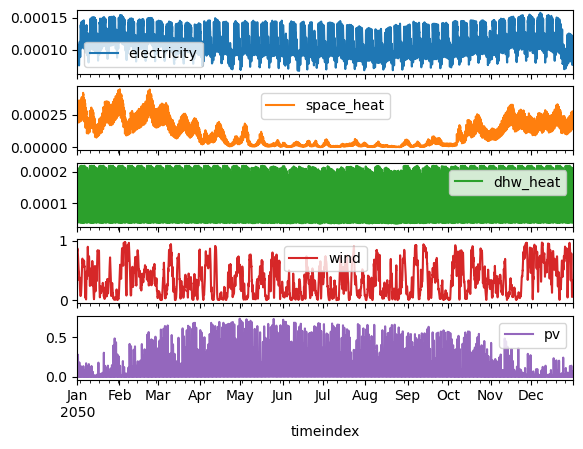

In [56]:
# Plot timeseries data
timeseries.plot(subplots=True)

<AxesSubplot:title={'center':'Electricity Wasted'}, xlabel='timeindex', ylabel='[MWh]'>

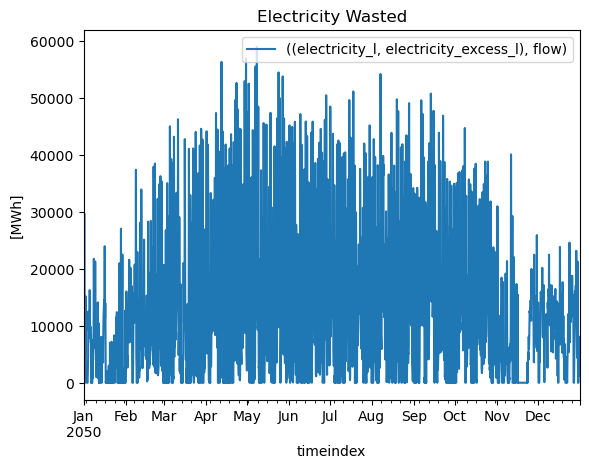

In [57]:
results_elec_excess = solph.views.node(results, 'electricity_excess_l')
results_elec_excess['sequences'].plot(title='Electricity Wasted', ylabel='[MWh]')

From the above plot we can observe that a lot of power is being wasted during the summer months since both PV and wind can supply at full potential and the demand is constant throughtout the year

<AxesSubplot:title={'center':'Battery Storage Usage'}, xlabel='timeindex', ylabel='[MWh]'>

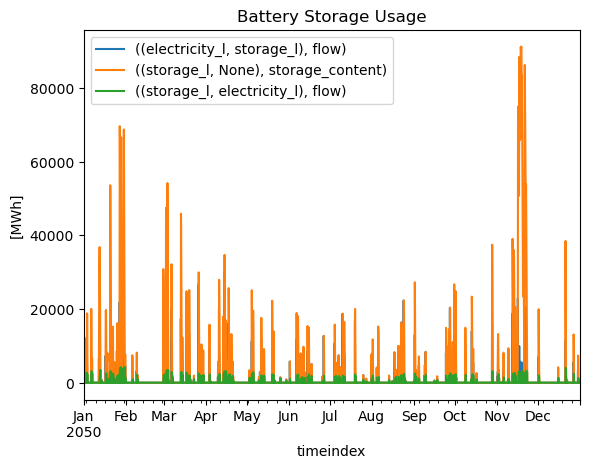

In [58]:
# Creating a plot for Battery storage usage throughout the year.

results_storage = solph.views.node(results, 'storage_l')
df = results_storage['sequences']
#df.iloc[:,1].plot(title='Battery Storage Usage', ylabel='Storage Capacity [MWh]', label='Storage')
df.plot(title='Battery Storage Usage', ylabel=['MWh'])


We can observe from above plot that storage hits the peak of 90GWh between Nov-Dec and storage peaks are during Nov-Feb months when PV production is not high

<AxesSubplot:title={'center':'Heat Pump Usage'}, xlabel='timeindex', ylabel='[MWh_th]'>

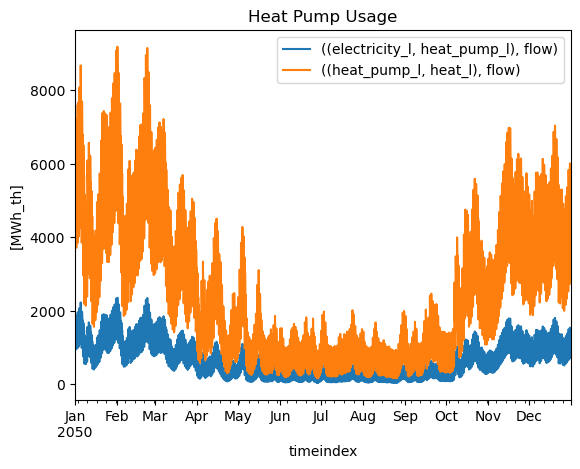

In [59]:
results_heat_pump = solph.views.node(results, 'heat_pump_l')
df1 = results_heat_pump['sequences']
df1.plot(title='Heat Pump Usage', ylabel=['MWh_th'])

From the above plot we can see that pump dispatch is very similar to the space heat demand

##### Exercise 3

What kind of problems do you see regarding results of the previous question. Is the model yet
a realistic representation of Schleswig-Holsteins future energy system?

We can observe that approx 80% of the electricity produced is wasted as excess. Only 24TWh of electricity was required to satisfy both electricity and heat demand, however 127.8TWh was produced. In my opinion this model would not be a realistic representation.

Additionally this model does not consider the land availability to setup these plants. If we consider land eligibility, then the potential for wind and PV setups wold drop significantly

Are investment results realistic?

This model would involve building a 91GWh capacity battery which would be an unreasonable investment. The heat pump capacity is realistic and satisfies the demand completely without any excess generation. The model suggests building both Solar and Wind plants and the capacities of both plants themselves generate more electricity than it is required in Schleswig-Holstein.

As per the meta results, the total cost of the system only with respect to capex will be €6.428 Billion  which is extremely high investment cost for a state like Schleswig-Holstein

By the end of 2022, PV capacity for entire Germany was at 66.5GW, so expecting a 65GW PV plant setup only for the state of SH would be quite a huge challenge. [Source](https://www.cleanenergywire.org/news/german-solar-power-capacity-2022-sees-fast-growth-still-well-below-target#:~:text=By%20the%20end%20of%202022,power%20production%20in%20the%20country.)

What kind of model improvements do you propose?

A cheaper storage option with long term storage option like Hydrogen or ACAES would be a better option than a Battery. This would also mean that we would be able to save more storage during peak production and avoid expanding the wind/pv plants to a larger capacity to meet peak demands of electricity and heat. Furthermore we can also explore the option of thermal storage which would help utilize the excess electricity production for heat storage to support the system during high heat demand (during winters)

### Additional Observation - Gurobi

In [60]:
om1 = solph.Model(energysystem)

# Solving the energysystem
om1.solve(solver='gurobi')

{'Problem': [{'Name': 'x105128', 'Lower bound': 6428074654.221604, 'Upper bound': 6428074654.221604, 'Number of objectives': 1, 'Number of constraints': 87605, 'Number of variables': 78848, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 78848, 'Number of nonzeros': 223373, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '1.2020001411437988', 'Error rc': 0, 'Time': 2.065164566040039}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [61]:
results1 = solph.processing.results(om1)

In [62]:
# Extracting results for electricity generated
results_elec_ts = OrderedDict()
results_elec_ts['Wind [TWh]'] = results1[(wind, bus_electricity)]['sequences']['flow'].sum()/1e6
results_elec_ts['PV [TWh]'] = results1[(pv, bus_electricity)]['sequences']['flow'].sum()/1e6
results_elec_df = pd.DataFrame(results_elec_ts, index=[0]).T
results_elec_df.columns = ['Electricity Generated']

# Extracting results for electricity consumed/demand
results_elec_ts1 = OrderedDict()
results_elec_ts1['Electricity Demand [TWh]'] = results1[(bus_electricity, electricity_demand)]['sequences']['flow'].sum()/1e6
results_elec_ts1['Electricity to Heat Pump [TWh]'] = results1[(bus_electricity, heat_pump)]['sequences']['flow'].sum()/1e6
results_elec_ts1['Electricity Excess [TWh]'] = results1[(bus_electricity, electricity_excess)]['sequences']['flow'].sum()/1e6
results_elec_ts1['Battery Losses [TWh]'] = results1[(bus_electricity,storage)]['sequences']['flow'].sum()/1e6 - results1[(storage,bus_electricity)]['sequences']['flow'].sum()/1e6
results_elec_df1 = pd.DataFrame(results_elec_ts1, index=[0]).T
results_elec_df1.columns = ['Electricity Consumed']

# Combining to form one dataframe/table of results
combined_elec_df = pd.concat([results_elec_df, results_elec_df1], axis=1)
combined_elec_df = combined_elec_df.append(pd.Series(combined_elec_df.sum(), name='Total [TWh]'))
combined_elec_df

,Electricity Generated,Electricity Consumed
Wind [TWh],60.608893,NaN
PV [TWh],67.234976,NaN
Electricity Demand [TWh],NaN,18.596727
Electricity to Heat Pump [TWh],NaN,5.804495
Electricity Excess [TWh],NaN,99.838640
Battery Losses [TWh],NaN,3.604007
Total [TWh],127.843869,127.843869


In [63]:
#Extracting cost of the system from meta results

meta_results1 = solph.processing.meta_results(om1)
objective1 = meta_results1['objective']/1e9
print(f'The objective value (Total Cost) of the optimized model is €{round(objective1,3)} Billion ')

The objective value (Total Cost) of the optimized model is €6.428 Billion 


When the above model is solved using Gurobi - I observe that Electricity losses are lower by 3TWh and Battery losses are higher by 3TWh. However the total cost of the system remains the same with either solver